In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.utils.data as data
from pandas.plotting import parallel_coordinates

# (BoTorch imports for Bayesian optimization)
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood

print(f"Using BoTorch version: {botorch.__version__}")

Using BoTorch version: 0.14.0


# Data Pre-processing

In [2]:
# 1. Load your preprocessed CSV
df = pd.read_csv("processed_bank_marketing.csv")

# 2. Ensure no missing data
df = df.dropna()

# 3. Extract features, labels, and protected group
X = df.drop(columns=["deposit"])
y = df["deposit"].values
protected_attr = df["marital"].values  # 0, 1, 2 → single, married, divorced

# Ensure all columns are numeric (if necessary)
X = pd.get_dummies(X, drop_first=True)

# 4. Preprocess the data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_tensor, y_tensor, protected_attr, test_size=0.2, random_state=42
)

# 6. Define fairness metric (max-min demographic parity across marital groups)
def demographic_parity_diff(y_pred, protected_group):
    group_probs = [
        y_pred[protected_group == g].mean()
        for g in np.unique(protected_group)
    ]
    return max(group_probs) - min(group_probs)


# Nueral Net Definition

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_units, layers):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_units))
        self.layers.append(nn.ReLU())
        
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
            self.layers.append(nn.ReLU())
        
        self.output_layer = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.sigmoid(self.output_layer(x))

# Model Traning and Evaluation

In [4]:
def train_and_evaluate_nn(params):
    # Extract parameters
    layers = int(params[0].item())  # Number of layers
    units = int(params[1].item())   # Number of hidden units
    lr = 10 ** params[2].item()     # Learning rate (log scale)
    batch_size = int(params[3].item())  # Batch size
    
    # Print the parameters
    print(f"Training with: layers={layers}, units={units}, lr={lr:.6f}, batch_size={batch_size}")
    
    # Create data loaders
    train_data = data.TensorDataset(X_train, y_train)
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Initialize the model
    model = NeuralNetwork(X_train.shape[1], units, layers)
    
    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model
    epochs = 100
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print loss occasionally
        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = (y_pred > 0.5).float()  # Classify based on 0.5 threshold
    
    # Calculate accuracy and fairness
    acc = accuracy_score(y_test.numpy(), y_pred_class.numpy())
    fairness = demographic_parity_diff(y_pred_class.numpy(), m_test)
    
    print(f"  Results: Accuracy = {acc:.4f}, Fairness = {fairness:.4f}")
    
    # For MOO, we return a tensor with two objectives:
    # 1. Accuracy (to maximize)
    # 2. Negative fairness (to maximize, equivalent to minimizing fairness metric)
    return torch.tensor([acc, -fairness], dtype=torch.float32)

# Bayesian Optimization ( Fitting a GP as surrogate )

In [5]:
#  Here we MANNUALLY fit a GP model using Adam optimizer
def manual_fit_gp(model, train_x, train_y, training_iter=100, lr=0.1):
    # Define loss and optimizer
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    return model

# Define parameter bounds for BoTorch
bounds = torch.tensor([
    [1.0, 32.0, -5.0, 16.0],   # lower bounds: layers, units, log_lr, batch_size
    [4.0, 128.0, -1.0, 256.0]  # upper bounds: layers, units, log_lr, batch_size
], dtype=torch.float32)

# Generate initial points with multi-objective evaluation
def generate_initial_points(n_samples=10):
    print(f"Generating {n_samples} initial random points...")
    # Generate random points within bounds
    X_init = torch.rand(n_samples, 4)  # 4 parameters to optimize
    
    # Scale to the parameter ranges
    X_init = bounds[0] + X_init * (bounds[1] - bounds[0])
    
    # Evaluate each point
    Y_init = torch.zeros(n_samples, 2)  # 2 objectives: accuracy and fairness
    
    for i in range(n_samples):
        results = train_and_evaluate_nn(X_init[i])
        Y_init[i] = results
        print(f"  Trial {i+1}: acc={results[0]:.4f}, fairness={-results[1]:.4f}")
        
    return X_init, Y_init


# Running BoTorch MOO

We had gotten a warning :-
> InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444 gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
And the suggested 

In [ ]:
# Run Multi-Objective Bayesian optimization with BoTorch
def run_botorch_multi_objective_optimization(n_iterations=90):
    print("Initializing with random trials...")
    X_train, Y_train = generate_initial_points(n_samples=20)
    
    # Store all results
    all_X = X_train.clone()
    all_Y = Y_train.clone()
    
    # Set up reference point for hypervolume calculation
    # This represents the minimum acceptable performance
    # [min_accuracy, min_negative_fairness]
    ref_point = torch.tensor([0.5, -0.3])  # 50% accuracy, 0.3 fairness difference
    
    print(f"Starting optimization for {n_iterations} iterations...")
    
    for i in range(n_iterations):
        try:
            # 1. Fit a multi-output GP model
            # We need a separate GP for each objective
            models = []
            for j in range(Y_train.shape[1]):
                # Extract the j-th objective
                gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
                mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
                
                # Manual fitting
                gp = manual_fit_gp(gp, X_train, Y_train[:, j:j+1])
                models.append(gp)
            
            # Combine models into a ModelListGP
            model = ModelListGP(*models)
            
            # 2. Get the current Pareto frontier
            pareto_Y = Y_train
            
            # Create a partitioning of the non-dominated space
            partitioning = NondominatedPartitioning(ref_point=ref_point, Y=pareto_Y)
            
            # 3. Define the acquisition function (Expected Hypervolume Improvement)
            # This seeks to maximize the hypervolume of the Pareto frontier
            acq_func = ExpectedHypervolumeImprovement(
                model=model,
                ref_point=ref_point,
                partitioning=partitioning,
                objective=IdentityMCMultiOutputObjective()
            )
            
            # 4. Optimize the acquisition function
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=bounds,
                q=1,
                num_restarts=10,
                raw_samples=64
            )
            
        except Exception as e:
            print(f"Error in BoTorch optimization: {e}")
            print("Falling back to random sampling...")
            
            # Random sampling as fallback
            candidate = bounds[0] + torch.rand(1, 4) * (bounds[1] - bounds[0])
        
        # 5. Evaluate the new candidate
        print(f"\nIteration {i+1}/{n_iterations}:")
        print(f"Candidate: layers={int(candidate[0,0].item())}, units={int(candidate[0,1].item())}, "
            f"lr={10**candidate[0,2].item():.6f}, batch_size={int(candidate[0,3].item())}")
        
        results = train_and_evaluate_nn(candidate[0])
        
        # 6. Update training data
        X_train = torch.cat([X_train, candidate])
        Y_train = torch.cat([Y_train, results.unsqueeze(0)])
        
        # 7. Store all results
        all_X = torch.cat([all_X, candidate])
        all_Y = torch.cat([all_Y, results.unsqueeze(0)])
        
    return all_X, all_Y

# Run optimization
print("Starting Multi-Objective BoTorch optimization for Neural Network...")
all_X, all_Y = run_botorch_multi_objective_optimization(n_iterations=90)

# Extract results
accuracies = all_Y[:, 0].numpy()
fairness_values = -all_Y[:, 1].numpy()  # Convert back to positive values

Starting Multi-Objective BoTorch optimization for Neural Network...
Initializing with random trials...
Generating 20 initial random points...
Training with: layers=2, units=107, lr=0.000024, batch_size=119
  Epoch 20/100, Loss: 0.4797
  Epoch 40/100, Loss: 0.4371
  Epoch 60/100, Loss: 0.4232
  Epoch 80/100, Loss: 0.4157
  Epoch 100/100, Loss: 0.4144
  Results: Accuracy = 0.8030, Fairness = 0.1497
  Trial 1: acc=0.8030, fairness=0.1497
Training with: layers=2, units=46, lr=0.000041, batch_size=202
  Epoch 20/100, Loss: 0.5879
  Epoch 40/100, Loss: 0.4762
  Epoch 60/100, Loss: 0.4395
  Epoch 80/100, Loss: 0.4281
  Epoch 100/100, Loss: 0.4199
  Results: Accuracy = 0.8021, Fairness = 0.1445
  Trial 2: acc=0.8021, fairness=0.1445
Training with: layers=3, units=99, lr=0.000013, batch_size=211
  Epoch 20/100, Loss: 0.6145
  Epoch 40/100, Loss: 0.4810
  Epoch 60/100, Loss: 0.4444
  Epoch 80/100, Loss: 0.4332
  Epoch 100/100, Loss: 0.4229
  Results: Accuracy = 0.8030, Fairness = 0.1527
  Trial 

/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3867
  Epoch 40/100, Loss: 0.3657
  Epoch 60/100, Loss: 0.3487
  Epoch 80/100, Loss: 0.3343
  Epoch 100/100, Loss: 0.3201
  Results: Accuracy = 0.8155, Fairness = 0.1621
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 2/90:
Candidate: layers=1, units=51, lr=0.000026, batch_size=55
Training with: layers=1, units=51, lr=0.000026, batch_size=55


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.5745
  Epoch 40/100, Loss: 0.5006
  Epoch 60/100, Loss: 0.4610
  Epoch 80/100, Loss: 0.4441
  Epoch 100/100, Loss: 0.4361
  Results: Accuracy = 0.8007, Fairness = 0.1451
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 3/90:
Candidate: layers=2, units=39, lr=0.018579, batch_size=229
Training with: layers=2, units=39, lr=0.018579, batch_size=229


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3470
  Epoch 40/100, Loss: 0.2986
  Epoch 60/100, Loss: 0.2677
  Epoch 80/100, Loss: 0.2410
  Epoch 100/100, Loss: 0.2339
  Results: Accuracy = 0.8070, Fairness = 0.1342
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 4/90:
Candidate: layers=2, units=118, lr=0.066371, batch_size=237
Training with: layers=2, units=118, lr=0.066371, batch_size=237


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3853
  Epoch 40/100, Loss: 0.3539
  Epoch 60/100, Loss: 0.3224
  Epoch 80/100, Loss: 0.3121
  Epoch 100/100, Loss: 0.3028
  Results: Accuracy = 0.8025, Fairness = 0.1117
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 5/90:
Candidate: layers=3, units=76, lr=0.000642, batch_size=248
Training with: layers=3, units=76, lr=0.000642, batch_size=248


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3974
  Epoch 40/100, Loss: 0.3664
  Epoch 60/100, Loss: 0.3583
  Epoch 80/100, Loss: 0.3397
  Epoch 100/100, Loss: 0.3278
  Results: Accuracy = 0.8092, Fairness = 0.1316
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 6/90:
Candidate: layers=3, units=63, lr=0.000761, batch_size=140
Training with: layers=3, units=63, lr=0.000761, batch_size=140


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3642
  Epoch 40/100, Loss: 0.3271
  Epoch 60/100, Loss: 0.2945
  Epoch 80/100, Loss: 0.2632
  Epoch 100/100, Loss: 0.2362
  Results: Accuracy = 0.7904, Fairness = 0.1170
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 7/90:
Candidate: layers=1, units=89, lr=0.000016, batch_size=53
Training with: layers=1, units=89, lr=0.000016, batch_size=53


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.5819
  Epoch 40/100, Loss: 0.5130
  Epoch 60/100, Loss: 0.4725
  Epoch 80/100, Loss: 0.4520
  Epoch 100/100, Loss: 0.4427
  Results: Accuracy = 0.7971, Fairness = 0.1415
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 8/90:
Candidate: layers=1, units=52, lr=0.000031, batch_size=18
Training with: layers=1, units=52, lr=0.000031, batch_size=18


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4654
  Epoch 40/100, Loss: 0.4374
  Epoch 60/100, Loss: 0.4284
  Epoch 80/100, Loss: 0.4203
  Epoch 100/100, Loss: 0.4152
  Results: Accuracy = 0.7998, Fairness = 0.1563
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 9/90:
Candidate: layers=2, units=37, lr=0.011108, batch_size=47
Training with: layers=2, units=37, lr=0.011108, batch_size=47


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3425
  Epoch 40/100, Loss: 0.2993
  Epoch 60/100, Loss: 0.2629
  Epoch 80/100, Loss: 0.2408
  Epoch 100/100, Loss: 0.2341
  Results: Accuracy = 0.7976, Fairness = 0.1108
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 10/90:
Candidate: layers=3, units=121, lr=0.011620, batch_size=24
Training with: layers=3, units=121, lr=0.011620, batch_size=24


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3412
  Epoch 40/100, Loss: 0.2921
  Epoch 60/100, Loss: 0.2485
  Epoch 80/100, Loss: 0.2311
  Epoch 100/100, Loss: 0.2215
  Results: Accuracy = 0.7900, Fairness = 0.1463
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 11/90:
Candidate: layers=1, units=124, lr=0.015681, batch_size=75
Training with: layers=1, units=124, lr=0.015681, batch_size=75


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3658
  Epoch 40/100, Loss: 0.3406
  Epoch 60/100, Loss: 0.3252
  Epoch 80/100, Loss: 0.2984
  Epoch 100/100, Loss: 0.2877
  Results: Accuracy = 0.8043, Fairness = 0.1448
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 12/90:
Candidate: layers=3, units=85, lr=0.000011, batch_size=114
Training with: layers=3, units=85, lr=0.000011, batch_size=114


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.5822
  Epoch 40/100, Loss: 0.4595
  Epoch 60/100, Loss: 0.4357
  Epoch 80/100, Loss: 0.4259
  Epoch 100/100, Loss: 0.4212
  Results: Accuracy = 0.8025, Fairness = 0.1474
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 13/90:
Candidate: layers=1, units=53, lr=0.000057, batch_size=171
Training with: layers=1, units=53, lr=0.000057, batch_size=171


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.5691
  Epoch 40/100, Loss: 0.4975
  Epoch 60/100, Loss: 0.4612
  Epoch 80/100, Loss: 0.4439
  Epoch 100/100, Loss: 0.4356
  Results: Accuracy = 0.8007, Fairness = 0.1542
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 14/90:
Candidate: layers=3, units=118, lr=0.000042, batch_size=201
Training with: layers=3, units=118, lr=0.000042, batch_size=201


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4302
  Epoch 40/100, Loss: 0.4095
  Epoch 60/100, Loss: 0.3976
  Epoch 80/100, Loss: 0.3900
  Epoch 100/100, Loss: 0.3823
  Results: Accuracy = 0.8079, Fairness = 0.1403
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 15/90:
Candidate: layers=3, units=55, lr=0.006193, batch_size=153
Training with: layers=3, units=55, lr=0.006193, batch_size=153


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3259
  Epoch 40/100, Loss: 0.2606
  Epoch 60/100, Loss: 0.1703
  Epoch 80/100, Loss: 0.1362
  Epoch 100/100, Loss: 0.0759
  Results: Accuracy = 0.7873, Fairness = 0.1172
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 16/90:
Candidate: layers=1, units=46, lr=0.000856, batch_size=112
Training with: layers=1, units=46, lr=0.000856, batch_size=112


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4007
  Epoch 40/100, Loss: 0.3876
  Epoch 60/100, Loss: 0.3788
  Epoch 80/100, Loss: 0.3723
  Epoch 100/100, Loss: 0.3672
  Results: Accuracy = 0.8115, Fairness = 0.1476
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 17/90:
Candidate: layers=1, units=36, lr=0.000082, batch_size=119
Training with: layers=1, units=36, lr=0.000082, batch_size=119


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.5546
  Epoch 40/100, Loss: 0.4728
  Epoch 60/100, Loss: 0.4438
  Epoch 80/100, Loss: 0.4507
  Epoch 100/100, Loss: 0.4250
  Results: Accuracy = 0.8030, Fairness = 0.1364
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 18/90:
Candidate: layers=1, units=87, lr=0.030279, batch_size=253
Training with: layers=1, units=87, lr=0.030279, batch_size=253


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3709
  Epoch 40/100, Loss: 0.3429
  Epoch 60/100, Loss: 0.3332
  Epoch 80/100, Loss: 0.3154
  Epoch 100/100, Loss: 0.3011
  Results: Accuracy = 0.8088, Fairness = 0.1162
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 19/90:
Candidate: layers=2, units=83, lr=0.029623, batch_size=249
Training with: layers=2, units=83, lr=0.029623, batch_size=249


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3357
  Epoch 40/100, Loss: 0.2803
  Epoch 60/100, Loss: 0.2312
  Epoch 80/100, Loss: 0.1991
  Epoch 100/100, Loss: 0.1805
  Results: Accuracy = 0.7949, Fairness = 0.1057
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 20/90:
Candidate: layers=2, units=79, lr=0.013831, batch_size=194
Training with: layers=2, units=79, lr=0.013831, batch_size=194


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3411
  Epoch 40/100, Loss: 0.2765
  Epoch 60/100, Loss: 0.2531
  Epoch 80/100, Loss: 0.2004
  Epoch 100/100, Loss: 0.1537
  Results: Accuracy = 0.7801, Fairness = 0.1230
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 21/90:
Candidate: layers=1, units=96, lr=0.000246, batch_size=224
Training with: layers=1, units=96, lr=0.000246, batch_size=224


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4430
  Epoch 40/100, Loss: 0.4176
  Epoch 60/100, Loss: 0.4050
  Epoch 80/100, Loss: 0.3968
  Epoch 100/100, Loss: 0.3914
  Results: Accuracy = 0.8056, Fairness = 0.1343
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 22/90:
Candidate: layers=2, units=110, lr=0.002203, batch_size=131
Training with: layers=2, units=110, lr=0.002203, batch_size=131


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3441
  Epoch 40/100, Loss: 0.2645
  Epoch 60/100, Loss: 0.1968
  Epoch 80/100, Loss: 0.1435
  Epoch 100/100, Loss: 0.1076
  Results: Accuracy = 0.7819, Fairness = 0.1677
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 23/90:
Candidate: layers=2, units=47, lr=0.022218, batch_size=156
Training with: layers=2, units=47, lr=0.022218, batch_size=156


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3444
  Epoch 40/100, Loss: 0.3026
  Epoch 60/100, Loss: 0.2690
  Epoch 80/100, Loss: 0.2407
  Epoch 100/100, Loss: 0.2329
  Results: Accuracy = 0.8124, Fairness = 0.1411
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 24/90:
Candidate: layers=1, units=87, lr=0.025260, batch_size=46
Training with: layers=1, units=87, lr=0.025260, batch_size=46


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3860
  Epoch 40/100, Loss: 0.3769
  Epoch 60/100, Loss: 0.3667
  Epoch 80/100, Loss: 0.3574
  Epoch 100/100, Loss: 0.3725
  Results: Accuracy = 0.8186, Fairness = 0.1341
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 25/90:
Candidate: layers=1, units=67, lr=0.032715, batch_size=62
Training with: layers=1, units=67, lr=0.032715, batch_size=62


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3885
  Epoch 40/100, Loss: 0.3829
  Epoch 60/100, Loss: 0.3595
  Epoch 80/100, Loss: 0.3582
  Epoch 100/100, Loss: 0.3537
  Results: Accuracy = 0.8101, Fairness = 0.1248
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 26/90:
Candidate: layers=2, units=87, lr=0.000841, batch_size=72
Training with: layers=2, units=87, lr=0.000841, batch_size=72


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3682
  Epoch 40/100, Loss: 0.3284
  Epoch 60/100, Loss: 0.3011
  Epoch 80/100, Loss: 0.2686
  Epoch 100/100, Loss: 0.2447
  Results: Accuracy = 0.8056, Fairness = 0.1397
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 27/90:
Candidate: layers=1, units=117, lr=0.000064, batch_size=17
Training with: layers=1, units=117, lr=0.000064, batch_size=17


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4285
  Epoch 40/100, Loss: 0.4085
  Epoch 60/100, Loss: 0.3994
  Epoch 80/100, Loss: 0.3927
  Epoch 100/100, Loss: 0.3882
  Results: Accuracy = 0.8061, Fairness = 0.1351
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 28/90:
Candidate: layers=1, units=101, lr=0.000115, batch_size=168
Training with: layers=1, units=101, lr=0.000115, batch_size=168


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4863
  Epoch 40/100, Loss: 0.4371
  Epoch 60/100, Loss: 0.4245
  Epoch 80/100, Loss: 0.4137
  Epoch 100/100, Loss: 0.4060
  Results: Accuracy = 0.8065, Fairness = 0.1411
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 29/90:
Candidate: layers=1, units=50, lr=0.000099, batch_size=39
Training with: layers=1, units=50, lr=0.000099, batch_size=39


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.4403
  Epoch 40/100, Loss: 0.4198
  Epoch 60/100, Loss: 0.4098
  Epoch 80/100, Loss: 0.4036
  Epoch 100/100, Loss: 0.3992
  Results: Accuracy = 0.8070, Fairness = 0.1296
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 30/90:
Candidate: layers=1, units=116, lr=0.018354, batch_size=220
Training with: layers=1, units=116, lr=0.018354, batch_size=220


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3555
  Epoch 40/100, Loss: 0.3278
  Epoch 60/100, Loss: 0.3135
  Epoch 80/100, Loss: 0.3004
  Epoch 100/100, Loss: 0.2788
  Results: Accuracy = 0.7971, Fairness = 0.1588
Error in BoTorch optimization: grad can be implicitly created only for scalar outputs
Falling back to random sampling...

Iteration 31/90:
Candidate: layers=2, units=102, lr=0.063252, batch_size=86
Training with: layers=2, units=102, lr=0.063252, batch_size=86


/tmp/ipykernel_1413290/63694428.py:24: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(X_train, Y_train[:, j:j+1])
/home/nira/Documents/code/aiml/MultiObjective_Machine_Learning/.conda/lib/python3.11/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


  Epoch 20/100, Loss: 0.3911
  Epoch 40/100, Loss: 0.3615


# Exploration and Pareto Points 

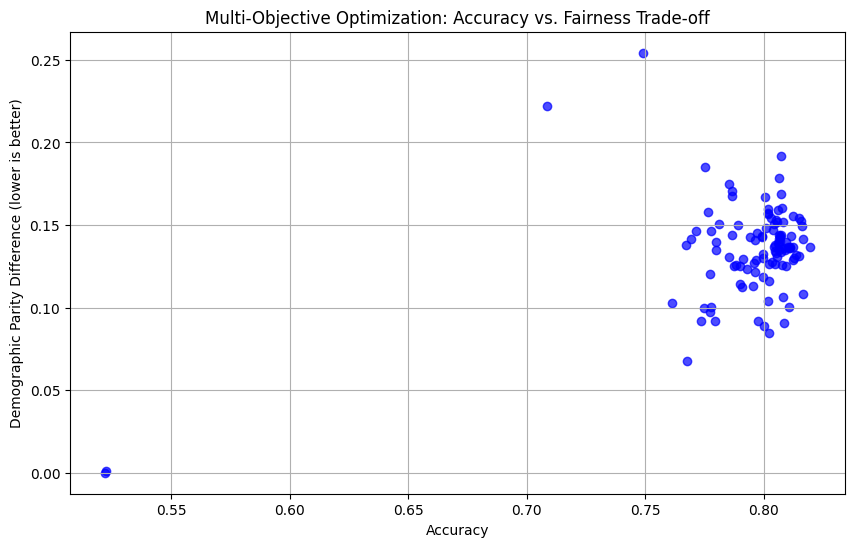

In [ ]:
# 15. Plot the results (All trials)
plt.figure(figsize=(10, 6))
plt.scatter(accuracies, fairness_values, c="blue", alpha=0.7)
plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Multi-Objective Optimization: Accuracy vs. Fairness Trade-off")
plt.grid(True)
plt.savefig("botorch_multi_objective_all_trials.png")
plt.show()

# 16. Find and visualize the Pareto frontier
# Helper function to determine if a point is Pareto-optimal
def is_pareto_optimal(accuracies, fairness_values, idx):
    # For each candidate solution
    for i in range(len(accuracies)):
        if i != idx:  # Don't compare with itself
            # If another solution has better accuracy and better (lower) fairness
            if accuracies[i] >= accuracies[idx] and fairness_values[i] <= fairness_values[idx] and (
                accuracies[i] > accuracies[idx] or fairness_values[i] < fairness_values[idx]
            ):
                return False  # Not Pareto-optimal
    return True  # No better solution exists

# Function to filter the Pareto front to get better spread (if too many points)
def filter_pareto_front(accuracies, fairness_values, target_points=40):
    """Filter Pareto front to get a well-distributed set of points"""
    if len(accuracies) <= target_points:
        return np.arange(len(accuracies))
    
    # Sort by accuracy
    sort_idx = np.argsort(accuracies)
    acc_sorted = accuracies[sort_idx]
    fair_sorted = fairness_values[sort_idx]
    
    # Calculate ranges
    acc_range = acc_sorted[-1] - acc_sorted[0]
    fair_range = fair_sorted[-1] - fair_sorted[0]
    
    # Always keep endpoints
    keep_indices = [sort_idx[0], sort_idx[-1]]
    
    # Select points with approximately equal spacing in the normalized space
    points_to_add = target_points - 2
    
    if points_to_add > 0:
        step = len(acc_sorted) // (points_to_add + 1)
        for i in range(1, points_to_add + 1):
            idx = min(i * step, len(sort_idx) - 1)
            keep_indices.append(sort_idx[idx])
    
    return np.array(keep_indices)

# Find Pareto-optimal points
pareto_optimal = [
    is_pareto_optimal(accuracies, fairness_values, i)
    for i in range(len(accuracies))
]

# Extract Pareto-optimal solutions
pareto_accuracies = accuracies[pareto_optimal]
pareto_fairness = fairness_values[pareto_optimal]
pareto_indices = np.where(pareto_optimal)[0]

# Sort by accuracy for connecting the Pareto frontier
pareto_sort_idx = np.argsort(pareto_accuracies)
pareto_accuracies = pareto_accuracies[pareto_sort_idx]
pareto_fairness = pareto_fairness[pareto_sort_idx]
pareto_indices = pareto_indices[pareto_sort_idx]

In [ ]:
# Filter if we have too many points, to get a better spread
print(f"Found {len(pareto_indices)} Pareto-optimal points")
if len(pareto_indices) > 40:
    # Filter to get a good spread of points
    filtered_indices = filter_pareto_front(pareto_accuracies, pareto_fairness, target_points=40)
    pareto_accuracies = pareto_accuracies[filtered_indices]
    pareto_fairness = pareto_fairness[filtered_indices]
    pareto_indices = pareto_indices[filtered_indices]
    print(f"Filtered to {len(pareto_indices)} well-distributed points on the Pareto frontier")

# Extract parameters for Pareto-optimal solutions
pareto_params = all_X[pareto_indices].numpy()


Found 8 Pareto-optimal points



Pareto-Optimal Neural Network Configurations:
1. layers=2, units=119, lr=0.094326, batch_size=62, acc=0.5222, fairness=0.0000
2. layers=3, units=36, lr=0.050819, batch_size=19, acc=0.5226, fairness=0.0008
3. layers=3, units=126, lr=0.001281, batch_size=151, acc=0.7676, fairness=0.0679
4. layers=1, units=111, lr=0.019822, batch_size=206, acc=0.8025, fairness=0.0846
5. layers=1, units=122, lr=0.058729, batch_size=171, acc=0.8088, fairness=0.0906
6. layers=2, units=84, lr=0.015677, batch_size=38, acc=0.8106, fairness=0.1004
7. layers=1, units=113, lr=0.073615, batch_size=235, acc=0.8168, fairness=0.1082
8. layers=3, units=53, lr=0.052327, batch_size=102, acc=0.8195, fairness=0.1369


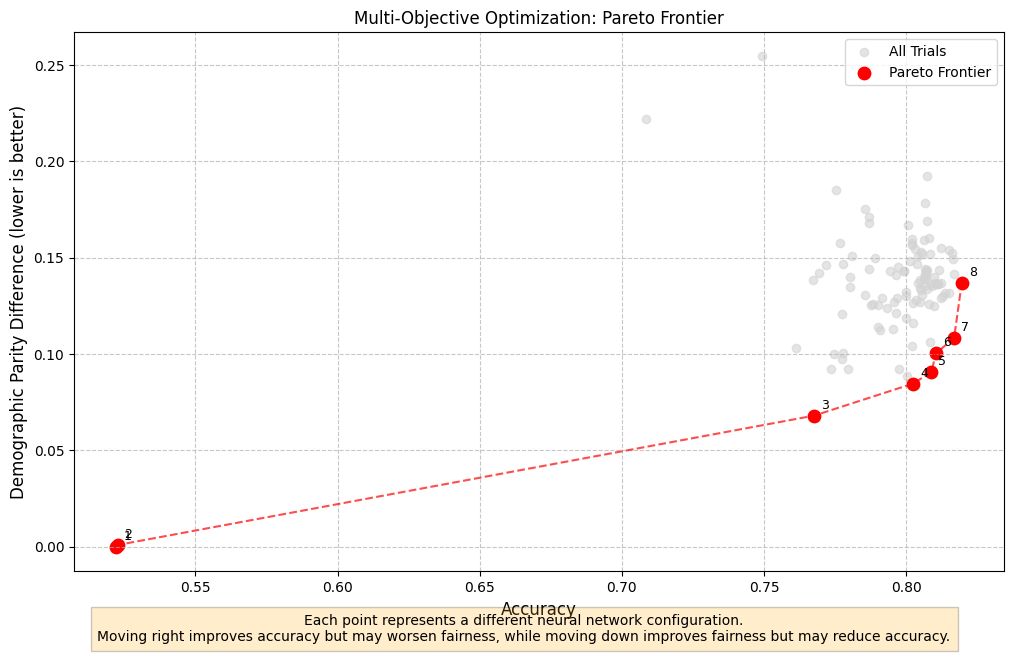

In [ ]:
#  Print Pareto-optimal parameter settings
print("\nPareto-Optimal Neural Network Configurations:")
for i in range(len(pareto_indices)):
    idx = pareto_indices[i]
    params = {
        "layers": int(all_X[idx, 0].item()),
        "units": int(all_X[idx, 1].item()),
        "learning_rate": 10 ** all_X[idx, 2].item(),
        "batch_size": int(all_X[idx, 3].item())
    }
    print(f"{i+1}. layers={params['layers']}, units={params['units']}, " 
          f"lr={params['learning_rate']:.6f}, batch_size={params['batch_size']}, "
          f"acc={accuracies[idx]:.4f}, fairness={fairness_values[idx]:.4f}")

# Visualize the Pareto frontier
plt.figure(figsize=(12, 7))
plt.scatter(accuracies, fairness_values, color="lightgray", alpha=0.6, label="All Trials")
plt.scatter(pareto_accuracies, pareto_fairness, color="red", s=80, label="Pareto Frontier")
plt.plot(pareto_accuracies, pareto_fairness, 'r--', alpha=0.7)  # Connect Pareto points

# Add annotations
for i, (x, y) in enumerate(zip(pareto_accuracies, pareto_fairness)):
    plt.annotate(f"{i+1}", (x, y), textcoords="offset points", xytext=(5, 5), fontsize=9)

# Add detailed formatting
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Fairness Gap (lower is better)", fontsize=12)
plt.title("Multi-Objective Optimization: Pareto Frontier", fontsize=14)
plt.legend(fontsize=11)

# Add text explaining the trade-off
plt.figtext(0.5, 0.01, 
           "Each point represents a different neural network configuration.\n"
           "Moving right improves accuracy but may worsen fairness, while moving down improves fairness but may reduce accuracy.", 
           ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.xlabel("Accuracy")
plt.ylabel("Demographic Parity Difference (lower is better)")
plt.title("Multi-Objective Optimization: Pareto Frontier")
plt.legend()
plt.grid(True)
plt.savefig("botorch_multi_objective_pareto_frontier.png")
plt.show()

# Additional Visualizations

In [ ]:
# Create a parallel coordinates plot to visualize parameters of Pareto solutions
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
pareto_df = pd.DataFrame({
    'layers': pareto_params[:, 0],
    'units': pareto_params[:, 1],
    'log_lr': pareto_params[:, 2],
    'batch_size': pareto_params[:, 3],
    'accuracy': pareto_accuracies,
    'fairness': pareto_fairness,
    'config_id': range(1, len(pareto_params) + 1)
})

## PART A :- Parameter analysis for Pareto-optimal solutions

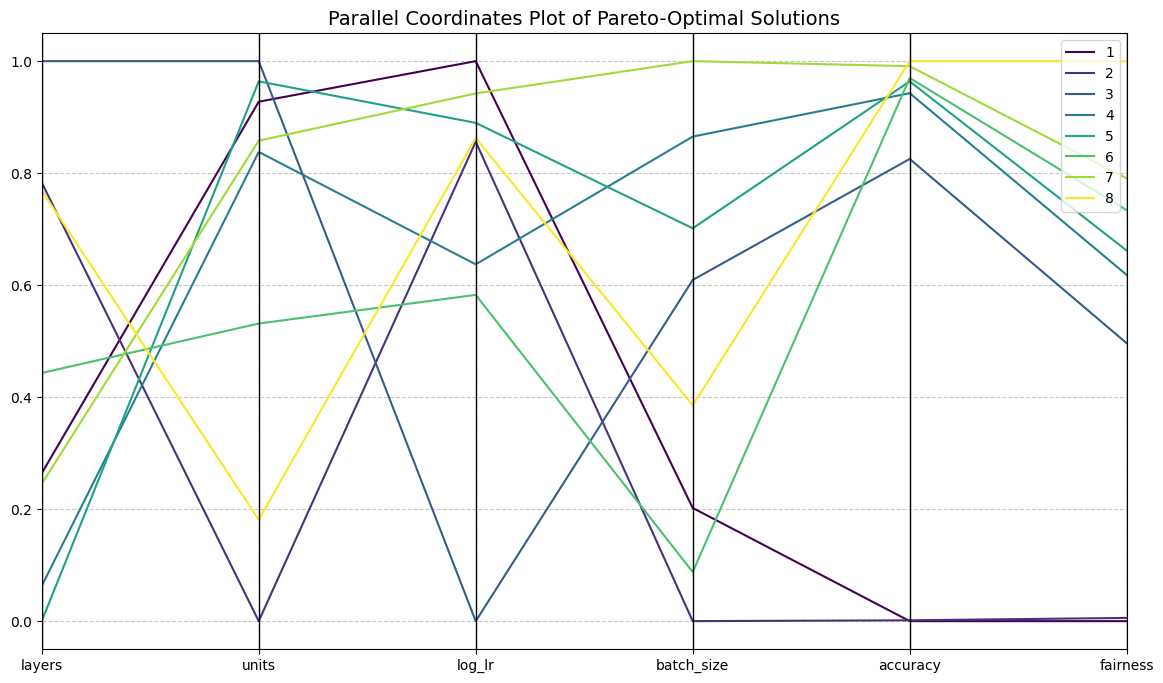

In [ ]:
# Parameter analysis for Pareto-optimal solutions
pareto_params = all_X[pareto_indices].numpy()

# Normalize the parameters for better visualization
for col in ['layers', 'units', 'log_lr', 'batch_size', 'accuracy', 'fairness']:
    pareto_df[col] = (pareto_df[col] - pareto_df[col].min()) / (pareto_df[col].max() - pareto_df[col].min())

plt.figure(figsize=(14, 8))
parallel_coordinates(pareto_df, 'config_id', colormap='viridis')
plt.title('Parallel Coordinates Plot of Pareto-Optimal Solutions', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("botorch_multi_objective_parallel_coords.png")
plt.show()

## PART B :- 3D visualization of the parameter space

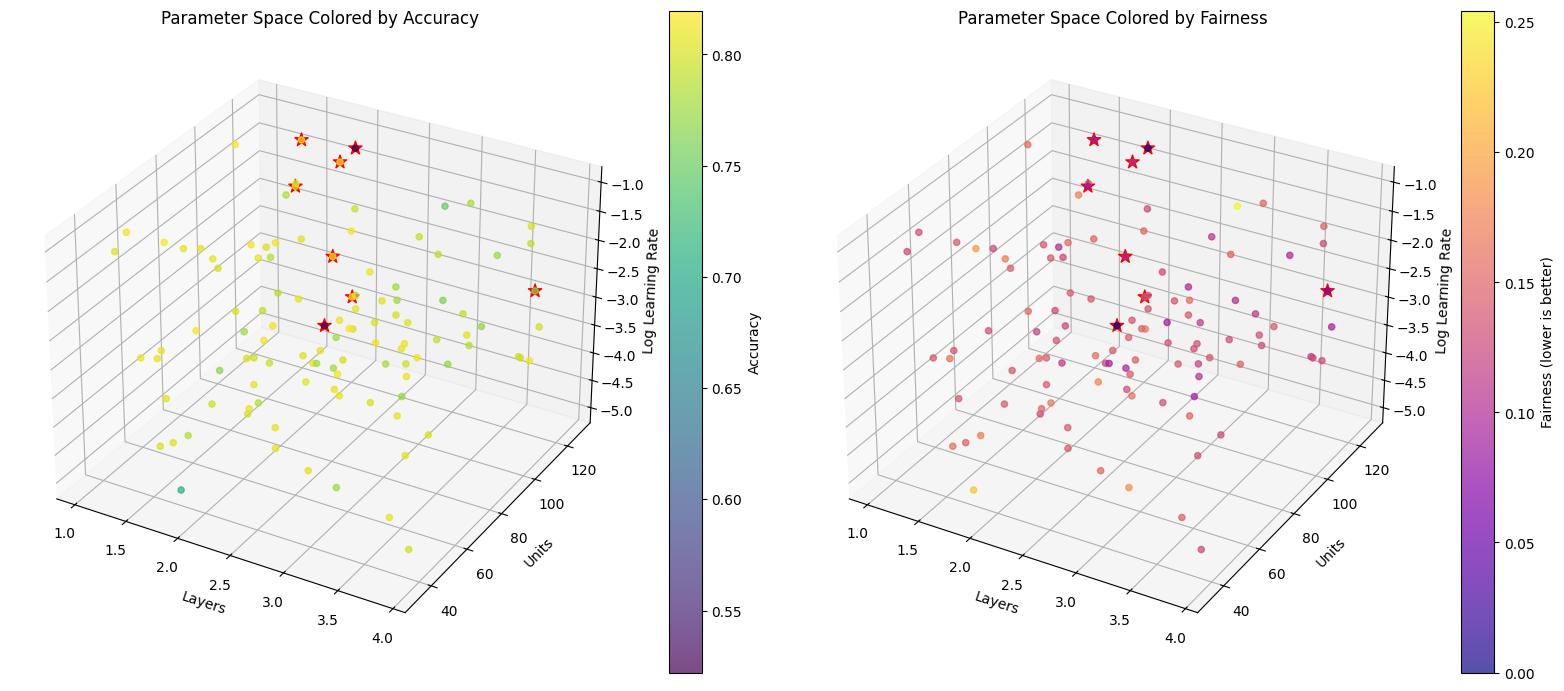

In [ ]:
# 3D visualization of the parameter space
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with two subplots
fig = plt.figure(figsize=(16, 7))

# Plot 1: Layers vs Units, colored by accuracy
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    all_X[:, 0].numpy(),  # layers
    all_X[:, 1].numpy(),  # units
    all_X[:, 2].numpy(),  # log learning rate
    c=accuracies,
    cmap='viridis',
    alpha=0.7
)
ax1.set_xlabel('Layers')
ax1.set_ylabel('Units')
ax1.set_zlabel('Log Learning Rate')
plt.colorbar(scatter1, ax=ax1, label='Accuracy')
ax1.set_title('Parameter Space Colored by Accuracy')

# Highlight Pareto-optimal points
ax1.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

# Plot 2: Layers vs Units, colored by fairness
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    all_X[:, 0].numpy(),  # layers
    all_X[:, 1].numpy(),  # units
    all_X[:, 2].numpy(),  # log learning rate
    c=fairness_values,
    cmap='plasma',
    alpha=0.7
)
ax2.set_xlabel('Layers')
ax2.set_ylabel('Units')
ax2.set_zlabel('Log Learning Rate')
plt.colorbar(scatter2, ax=ax2, label='Fairness (lower is better)')
ax2.set_title('Parameter Space Colored by Fairness')

# Highlight Pareto-optimal points
ax2.scatter(
    pareto_params[:, 0],
    pareto_params[:, 1],
    pareto_params[:, 2],
    color='red',
    s=100,
    alpha=1.0,
    marker='*'
)

plt.tight_layout()
plt.savefig("botorch_multi_objective_parameter_space.png")
plt.show()


## PART C :- Heatmap of Hyperparameter impact on Objectives

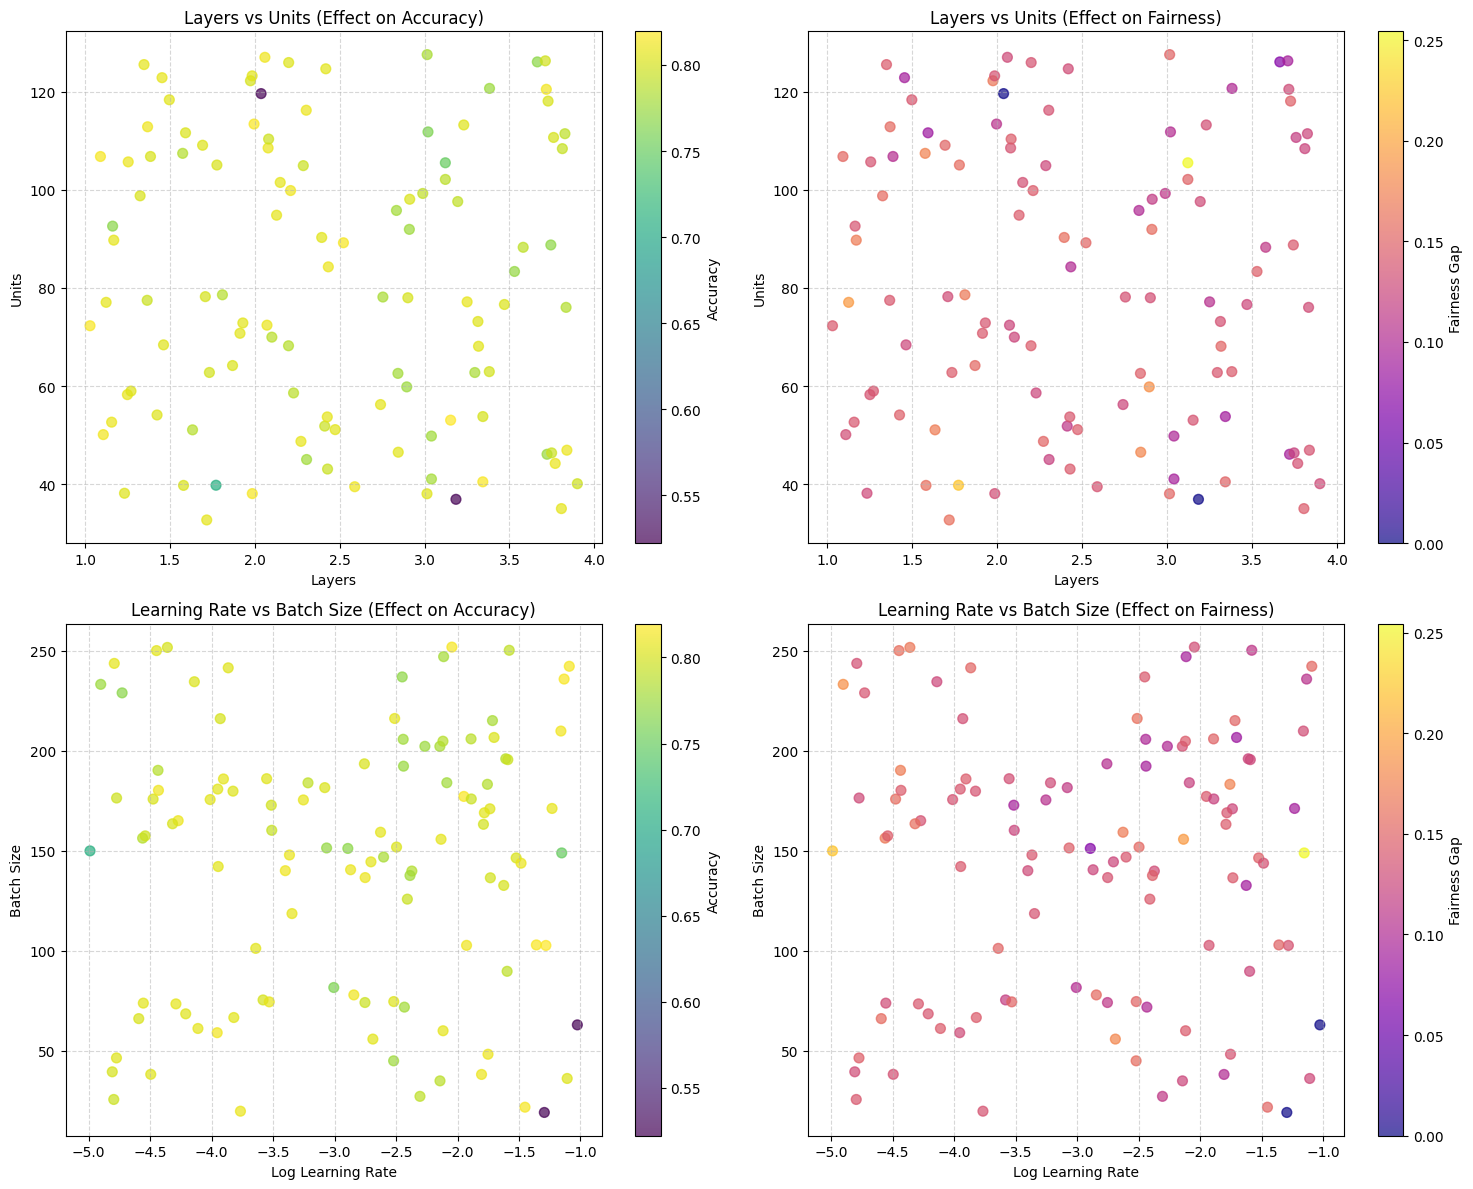

In [ ]:
#  Create a heatmap visualization of hyperparameter impact on objectives
plt.figure(figsize=(15, 12))

# Create subplots for different parameter combinations
plt.subplot(2, 2, 1)
plt.scatter(all_X[:, 0].numpy(), all_X[:, 1].numpy(), c=accuracies, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Accuracy')
plt.xlabel('Layers')
plt.ylabel('Units')
plt.title('Layers vs Units (Effect on Accuracy)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
plt.scatter(all_X[:, 0].numpy(), all_X[:, 1].numpy(), c=fairness_values, cmap='plasma', alpha=0.7, s=50)
plt.colorbar(label='Fairness Gap')
plt.xlabel('Layers')
plt.ylabel('Units')
plt.title('Layers vs Units (Effect on Fairness)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
plt.scatter(all_X[:, 2].numpy(), all_X[:, 3].numpy(), c=accuracies, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(label='Accuracy')
plt.xlabel('Log Learning Rate')
plt.ylabel('Batch Size')
plt.title('Learning Rate vs Batch Size (Effect on Accuracy)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 4)
plt.scatter(all_X[:, 2].numpy(), all_X[:, 3].numpy(), c=fairness_values, cmap='plasma', alpha=0.7, s=50)
plt.colorbar(label='Fairness Gap')
plt.xlabel('Log Learning Rate')
plt.ylabel('Batch Size')
plt.title('Learning Rate vs Batch Size (Effect on Fairness)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("botorch_multi_objective_heatmaps.png")
plt.show()